In [1]:
import pylab
import h5py
import math
import array

import numpy
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


In [2]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [3]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e*q + A[6]*(e**2)*q + A[7]*(e)*math.cos(l + A[8]) + A[9]*(e**1)*(q**1)*math.cos(e*l + A[10]) + A[11]*(e**2)*math.cos(l + A[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e*eta + B[6]*(e**2)*eta + B[7]*e*math.cos(l + B[8]) + B[9]*(e**1)*(eta**1)*math.cos(l + B[10]) + B[11]*(e**2)*math.cos(e*l + B[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e*eta + C[6]*(e**2)*eta + C[7]*e*eta*math.cos(l + C[8]) + C[9]*(e)*math.cos(l + C[10]) + C[11]*(e**2)*math.cos(e*l + C[12])

In [4]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [5]:
sph1,sph2 = sph_harmonics(0,2)
print(sph1,sph2)

0.6307831305050401 0.0


In [6]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [7]:
xconv(16.68,30)

0.03913912683431347

In [8]:
def eccmodel(Mass,q0,e0,l0,fmin,inclination=0,d=1,delta_t=1./4096,modes=[[2,2]]):
    
    #delta_t=0.00015208911520102518
    #delta_t = 1/2**20
    ell = []
    numrows = len(modes)
    numcols = len(modes[0])
    for i in range(0,numrows):
        l = modes[i][0]
        m = modes[i][1]
        ell.append(l)
    angle = inclination
    waveform = {}
    count = 0
    el = 2
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = model_22(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l2_m2'] = mode_data
        count = count + 1

    el = 3
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL33(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l3_m3'] = mode_data
        count = count + 1
        
    el = 4
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL44(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l4_m4'] = mode_data
        count = count + 1
        
    el = 5
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL55(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l5_m5'] = mode_data
        count = count + 1
        
    len_max_mode = '0'
    len_max = 0
    for mode in waveform.keys():
        if len(waveform[mode]['t'])>len_max:
            len_max_mode = mode
            len_max = len(waveform[mode]['t'])
            
    for mode in waveform.keys():
        if mode != len_max_mode:
            waveform[mode]['hp'].resize(len_max)
            waveform[mode]['hc'].resize(len_max)
            
    hp=0
    hc=0
    time=waveform[len_max_mode]['t']
    for mode in waveform.keys():
        hp = hp + waveform[mode]['hp']
        hc = hc + waveform[mode]['hc']
        
    hplus = TimeSeries(hp,delta_t,epoch=time[0])
    hcross = TimeSeries(hc,delta_t,epoch=time[0])
    
    return hplus, hcross

In [9]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='TaylorT2', mass1=M1, mass2=M2, 
                            delta_t=delta_t, 
                            f_lower=f_low, 
                            eccentricity=e0,
                            distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [11]:
def INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t,time_hyb):
    
    eta=neu=nu=q/(1+q)**2
    G=c=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    eta=nu=neu
    gamma=EulerGamma=0.577215664901
    mode2polfac=(5/(64*np.pi))**(1/2)
    
    conv=M*MTSUN_SI
    M_SI=M * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
    f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
    %run GW_functions.ipynb
    
    x=xlow
    v=math.sqrt(x)
    
    xie=v**3
    
    if delta_t>=1/2**14:
        del_t = 1/2**14
    elif delta_t<1/2**14 and delta_t>=1/2**16:
        del_t = 1/2**16
    elif delta_t<1/2**16 and delta_t>=1/2**18:
        del_t = 1/2**18
    else:
        del_t = 1/2**20
        
    #phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
    tVec_PN = np.arange(time_hyb, -500, 10)   #Turn on for omkar's code
    tC_NR = 0
    
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
   
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xband=np.where(xVec<=1/6)
    xVec = xVec[xband]
    maxPNidx = len(xVec)
    tVec_PN=tVec_PN[:maxPNidx]
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    
    W_term = []; XIE = []
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=mean_anomaly(xie, xi0, l0, eta, e0)
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        #psi = 2*phase_TT2(x**0.5, x0**0.5, e0, 0, eta) + 2*W(xie, xi0, eta, e0, l) #Old TT2 phase (Abhishek)
        psi= mp*New_phase_TT2(x, x0, e0, 0.0, 0.0, 0.0, M, nu, Delta)+2*W(xie, xi0, eta, e0, l) # New TT2 phase (Omkar)
        #psi = phase_EccTD[j]   # LAL approximant
        W_term.append(W(xie,xi0,eta,e0,l)); XIE.append(xie/(PI*2.8*MTSUN_SI))
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm)
        h2_2.append(hl_m)
        
    
    
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,sph22) #+np.multiply(h2_2,sph2_2)
    hp=(np.real(h)) 
    hc=(np.imag(h))
    
    #print(tVec_PN)
    time = tVec_PN - tVec_PN[-1]

    mode2polfac=(5/(64*np.pi))**(1/2)  
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = tVec_PN * conv_t
    
    hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp = np.arange(time.min(), time.max(), delta_t)
    hp_intrp = hp_intrp(t_intrp)
    hc_intrp = hc_intrp(t_intrp)
    
    #plt.plot(XIE,W_term)
    return np.array(hp_intrp), np.array(hc_intrp), np.array(t_intrp)

In [33]:
def MODEL22(m,q0,e0,l0,fmin,angle,d,delta_t):
    
    M=m
    M1=q0*M/(1+q0)
    M2=M/(1+q0)
    eta=q0/(1+q0)**2
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    #mode2polfac=(5/(64*np.pi))**(1/2)   
    inc = angle
    angle = (np.pi/180)*angle
    
    
    f = h5py.File('/home/pratul/Downloads/Project/New hybrids/Ebersold/1364_EccTD_Ebersold_HM_hyb.h5','r')
    #f = h5py.File('/home/pratul/Downloads/Project/New hybrids/TT2_Hybs/1364_TT2_Ebersold_22_hyb.h5','r')

        
    data = f['l2_m2']
    tVec = real(data[0:,0])
    h22pVec = real(data[0:,1])
    h22cVec = real(data[0:,2])
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    hpVec=h22pVec
    hcVec=h22cVec

    
    
    
    D_SI=(10**(6))*PC_SI
    tVec=tVec*M*MTSUN_SI
    hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
    
    
    delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
    #print(delta_t)
    h22Hyb = hpVec+1j*hcVec
    
    tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
    phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
    omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))
    
    
        
    
    
    hp, hc, tinsp = INSP_Eber22(M,q0,e0,l0,fmin,angle,d,delta_t,tVec[0]/(M*MTSUN_SI)) 
    
    
    
    #NR
    simulation = '/home/pratul/Downloads/Project/NR_data/1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
    sims = simulation.split('_')[0]
    lp = 2 #modes
    mp = 2
    tref = 640  # Varies depending on simulations
    mode = 'l'+str(lp)+'_m'+str(mp)
    with h5py.File(simulation, 'r') as hdf:
        temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
        test=np.array(temp)

    x1=test[:,0]
    y1=test[:,1]    
    z1=test[:,2]


    plotband=np.where(x1>=tref)
    x1=x1[plotband]
    x1=x1-x1[np.argmax(abs(y1))]
    y1=y1[plotband]    
    z1=z1[plotband]
    NRAmp = abs(y1-1j*z1)

    tot=y1-1j*z1
    amp=abs(tot)
    ph=np.angle(tot)
    phase_NR=np.unwrap(ph)
    w=np.absolute(diff(phase_NR)/diff(x1))
    phi0=phase_NR[0]
        
        
    #Circular IMR
    sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)

    h22IMR = sp+1j*sc
    
    tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    
    tmin = max(tinsp[0]-tshift, sp.sample_times[0],tVec[0])
    
    
    tImr_intrp = np.arange(tmin, sp.sample_times[-1], delta_t)
    tImr = tImr_intrp
    H_intrp = interp1d(sp.sample_times, h22IMR, kind='cubic', fill_value='extrapolate')
    h22Imr = H_intrp(tImr_intrp)
    
    
    
    
    
    #Interpolation Ebersold
    hp_intrp = interp1d(tinsp-tshift, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(tinsp-tshift, hc, kind='cubic',fill_value='extrapolate')
    tEcc_intrp = np.arange(tmin, tinsp[-1]-tshift, delta_t)
    hp_intrp = hp_intrp(tEcc_intrp)
    hc_intrp = hc_intrp(tEcc_intrp)
    tEcc = tEcc_intrp
    hpEcc = hp_intrp
    hcEcc = hc_intrp
    h22Ecc = hpEcc + 1j*hcEcc
    
    phaseEcc = np.unwrap(np.angle(h22Ecc)*2)/2
    phaseImr = np.unwrap(np.angle(h22Imr)*2)/2
    dphase = phaseEcc[0] - phaseImr[0]
    hp_new = real(h22Ecc * exp(-1j * dphase))
    hc_new = imag(h22Ecc * exp(-1j * dphase))
    
    phase_new = np.unwrap(np.angle(hp_new-1j*hc_new)*2)/2
    
    #phaseEcc = phase_new
    phaseEcc = phase_new #edit
    phaseImr = phaseImr #edit
    h22Ecc_new = (hp_new+1j*hc_new)
    
    arg = np.argmin(abs(tEcc-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
    Idxjoin = arg
    
    t_amp = tEcc[Idxjoin] - 500*M*MTSUN_SI
    idxstr = np.argmin(abs(tEcc-t_amp))
    
    #Amplitude Model
    amp=[]
    count=0
    length=Idxjoin-idxstr
    
    for i in range(idxstr,Idxjoin):
        amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
        count=count+1
    
    t_model=np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
    h22amp=np.concatenate((abs(h22Ecc_new[0:idxstr]),amp))
    h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))    
    
    omegaEcc = (M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
    omegaImr = (M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
    
    tjoin0 = tfreq_Hinsp(eta,e0,l0)
    #print(tjoin0)
    tjoin = tjoin0 * M * MTSUN_SI
    fjoin = np.argmin(abs(tEcc-tjoin))
        
    #frequency model
    tstop = min(tEcc[-1],-30*M*MTSUN_SI)
    lst=np.argmin(abs(tEcc-tstop))
    
    indx=lst - fjoin
    a0 = []
    n = indx-1
    k = 0
    for i in range(fjoin,fjoin+indx):
        a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
        k=k+1
    
    f1 = np.concatenate((omegaEcc[0:fjoin],a0))
    frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
    phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t)
    phase_f_model = phase_f_model - phase_f_model[0] + phaseEcc[0]
    
    hp_f_model = h22amp_model * np.cos(phase_f_model)
    hc_f_model = h22amp_model * np.sin(phase_f_model)
    
    #return np.array(hp_f_model), np.array(hc_f_model), np.array(t_model)
    
    #plt.figure(figsize=(12,4.8))
    #plt.plot(tVec/(M*MTSUN_SI), np.abs(h22Hyb),label='hyb',color='navajowhite')
    #plt.plot(tEcc/(M*MTSUN_SI), np.abs(h22Ecc_new),label='PN',color='green')
    #plt.plot(tImr/(M*MTSUN_SI), np.abs(h22Imr),label='EOB',color='blue')
    #plt.plot(t_model/(M*MTSUN_SI),h22amp_model,label='model',color='brown')
    #plt.xlim(xmin=-3350)
    #plt.xlim(xmax=500)
    
    
    
    
    
    
    
    
    #print('Mode = (2,2) , Inclination = ',inc,' degrees')
    #Plot
    plt.figure(figsize=(12,4))
    plt.rc('xtick', labelsize=16, direction ='in') 
    plt.rc('ytick', labelsize=16, direction ='in') 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=6)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    #plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=2,alpha = 0.9,label='hybrid',zorder=1)
    #plt.plot(t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color = 'saddlebrown',alpha=1,linewidth=1,linestyle='-',label='Model_22',zorder=3)
    plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
    #plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
    plt.plot(x1-x1[np.argmax(NRAmp)],NRAmp,label='NR',linewidth = 4, alpha=0.5,color='darkblue') #NR
    
    
    plt.xlim(xmin=-5000)
    plt.xlim(xmax=100)
    plt.ylim(ymin=1e-2)
    plt.ylim(ymax=4e-1)
    #plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
    #plt.xlabel(r'$t/M$',fontsize=22)
    #plt.yscale('log')
    plt.tight_layout()
    plt.legend(fontsize=15,frameon=False)
    
    
    plt.figure(figsize=(12,4))
    plt.rc('xtick', labelsize=16, direction ='in') 
    plt.rc('ytick', labelsize=16, direction ='in') 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=6)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    #plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='navajowhite',linewidth=6,alpha = 1,label='hybrid',zorder=1)
    #plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=1,label='Model_22',zorder=3)
    plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='TaylorT2',zorder=2)
    #plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
    plt.plot((x1-x1[np.argmax(NRAmp)])[:len(w)], w,color='darkblue',linewidth=4,alpha = 0.5,label='NR',zorder=1)
    
    plt.xlim(xmin=-5000)
    plt.xlim(xmax=100)
    plt.ylim(ymin=1e-2)
    plt.ylim(ymax=4e-1)
    #plt.ylabel(r'$M\omega_{22}$',fontsize=22,labelpad=5)
    #plt.xlabel(r'$t/M$',fontsize=22)
    plt.yscale('log')
    #plt.tight_layout()
    plt.legend(fontsize=15,frameon=False)
    #print(omegaImr[:1000]/omegaEcc[:1000])  
    
    delta_t = 1./4096
        # Setting up match calculation window
    t_start = max(tVec[0],t_model[0]); t_end = x1[-1]*M*MTSUN_SI  #max(tVec[0],t_model[0]) when window starts from t0

        
    Thyb_intrp = np.arange(t_start,t_end, delta_t)
    hphyb = interp1d(tVec/(M*MTSUN_SI),np.real(h22Hyb),kind='cubic',fill_value='extrapolate')
    hphyb = hphyb(Thyb_intrp/(M*MTSUN_SI))
        
        
    Tmod_intrp = np.arange(t_start,t_end, delta_t)
    hpmod = interp1d(t_model/(M*MTSUN_SI),hp_f_model,kind='cubic',fill_value='extrapolate')
    hpmod = hpmod(Tmod_intrp/(M*MTSUN_SI))
        
        
    plt.figure(figsize=(12,4))
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=6)
    plt.tick_params(axis='y',direction='in')
    plt.tick_params(axis='x',direction='in')
        
        
    #plt.plot(tVec/(M*MTSUN_SI),np.real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='cyan',linewidth=4,label='Hybrid')
    plt.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='lightsalmon',alpha=1,linestyle='-',linewidth=4,label='model')
    #plt.plot(tEcc/(M*MTSUN_SI),np.real(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
    plt.plot((x1-x1[np.argmax(NRAmp)]),y1,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'$h_+$',fontsize=20)
    plt.xlabel(r'$t/M$',fontsize=20)
    leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5})
    plt.xlim(-5000,100)
    plt.tight_layout()
    
    Hp_hybrid = TimeSeries(hphyb, delta_t, epoch=0) #hphyb for short window
    Hp_model = TimeSeries(hpmod, delta_t, epoch=0) #hpmod for short window
        
    #print(Hp_model[0],Hp_hybrid[0])
    #OMEGA22 = (1/delta_t)*(np.gradient(phase_f_model))
    #low_freq_cutoff = (OMEGA22/(2*PI))[0]
    #print('low_freq_cutoff = ',30*M*MTSUN_SI*low_freq_cutoff)
    
#Uncomment it for match calculations
    #M = []
    #tlen = max(len(Hp_hybrid),len(Hp_model))
    #Hp_hybrid.resize(tlen)
    #Hp_model.resize(tlen)
    #delta_f = 1./(Hp_hybrid.duration)
    #flen = tlen//2+1
    #f_low = fmin
    #psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    #print(len(Hp_model),len(Hp_hybrid))
    #m, i =match(Hp_model,Hp_hybrid,psd=psd,low_frequency_cutoff=f_low)
    #mismatch = 1-m
    #print('match = ',1-mismatch)
        

100%|█████████████████████████████████████| 3192/3192 [00:02<00:00, 1493.67it/s]


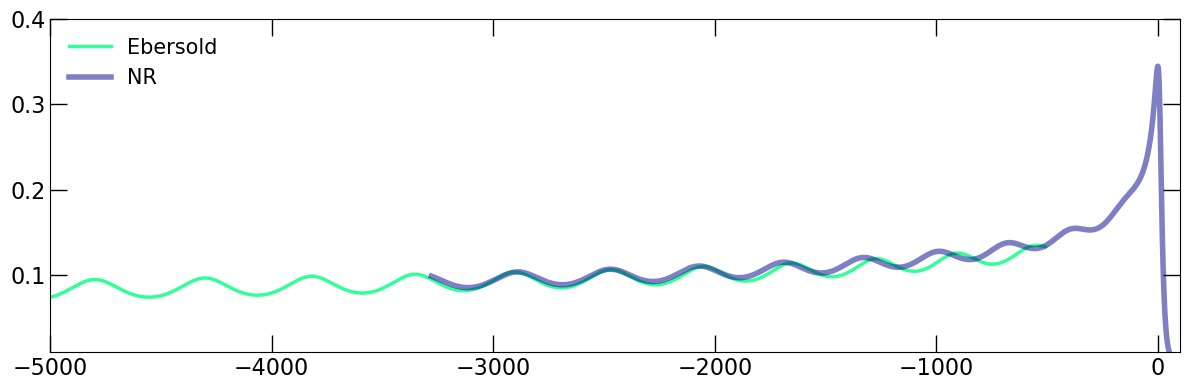

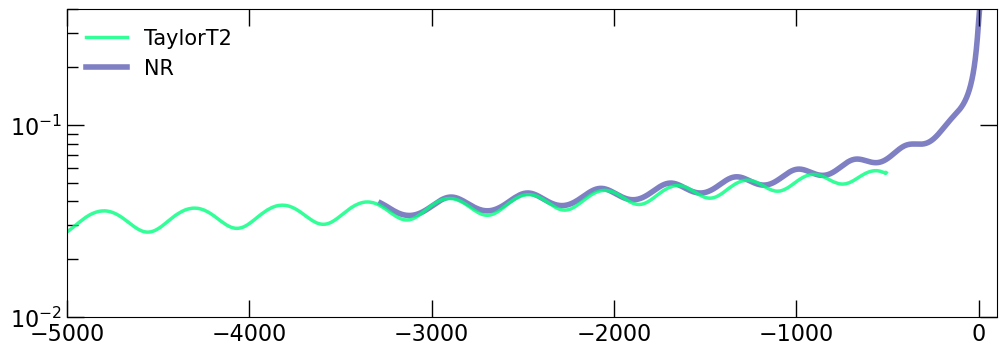

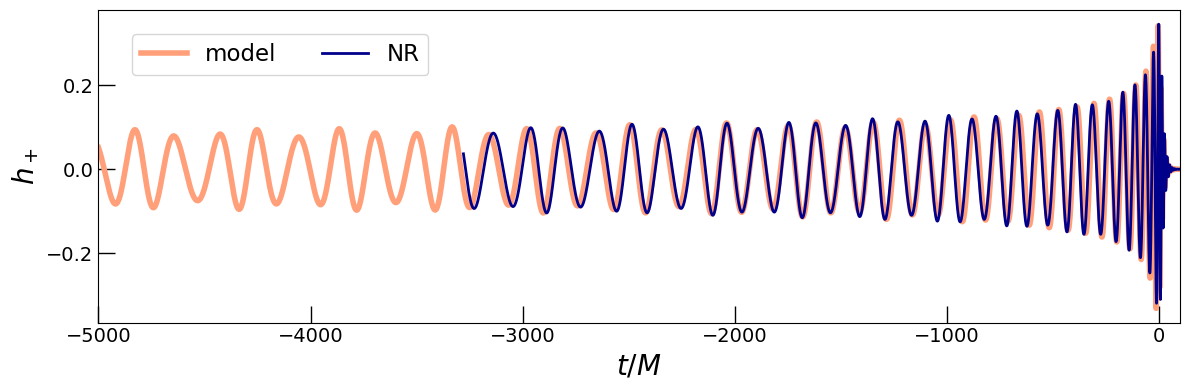

In [34]:
MODEL22(30,2,0.172,-0.181,16.68,0,1,1./4096)

In [ ]:
def EccTDparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                            delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [ ]:
def TT2params(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='TaylorT2', mass1=M1, mass2=M2, 
                            delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [ ]:
def TT3params(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='TaylorT3', mass1=M1, mass2=M2, 
                            delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [ ]:
def TT4params(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='TaylorT4', mass1=M1, mass2=M2, 
                            delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [ ]:
phase_EccTD, t_EccTD = EccTDparams(30,2,1,20,0.12,1./4096)
phase_TT2, t_TT2 = TT2params(30,2,1,20,0.12,1./4096)
phase_TT3, t_TT3 = TT3params(30,2,1,20,0.12,1./4096)
phase_TT4, t_TT4 = TT4params(30,2,1,20,0.12,1./4096)
plt.plot(t_EccTD,phase_EccTD,label='EccTD',linestyle='--')
plt.plot(t_TT2,phase_TT2,label='TT2')
plt.plot(t_TT3,phase_TT3,label='TT3')
plt.plot(t_TT4,phase_TT4,label='TT4')
plt.legend()

In [ ]:
from pycbc.waveform import td_approximants, fd_approximants
print(td_approximants())

In [ ]:
q= 1
eta = q/(1+q)**2
l0 = PI
e0 = 0.1
W_term = []; XIE = []
f = np.arange(100,1000,5)
xie = (PI*2.8*MTSUN_SI)*f
xi0 = (PI*2.8*MTSUN_SI)*f[0]
l=mean_anomaly(xie, xi0, l0, eta, e0)
plt.plot(f, W(xie, xi0, eta, 0.1, l))